In [1]:
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import mdof
from mdof.utilities.printing import plot_pred

# Load Files

In [2]:
# Path to the directory where files are saved
DATA_DIR = Path("../../uploads/mini_shake_table/Flexible vs. Stiff (3 story model)")
# Get all the files ending in csv
files = list(DATA_DIR.glob("**/*.csv"))
# Identify the row with the column labels
header_row = 8
# Get the column labels
with open(files[0], "r") as readfile:
    header_keys = readfile.readlines()[header_row-1].split(',')
# Identify the column indices for each acceleration component
x_index = header_keys.index('Acc_X')
y_index = header_keys.index('Acc_Y')
z_index = header_keys.index('Acc_Z')

# Populate a dictionary with the data. Each file is its own item.
data = {}
for file in files:
    filename = f"{file.parent.parent.name} {file.parent.name} - {file.name.split(')')[0]})"
    data[filename] = np.loadtxt(file,
                                delimiter=",",
                                skiprows=header_row, # Get all the rows after the header
                                usecols=[x_index,y_index,z_index] # Get only the columns with acceleration data
                               )

## Print the filenames used as keys in the `data` dictionary

In [3]:
# We'll use this list of filenames as reference for the options 
# of records used in the system identification code down below.

for filename in data.keys():
    print(filename)

Flexible walls 3rd Floor (top floor) - (Sine 1.5)
Flexible walls 3rd Floor (top floor) - (Northridge)
Flexible walls 3rd Floor (top floor) - (Sine 1.0)
Flexible walls 3rd Floor (top floor) - (Sine 2.0)
Flexible walls Ground Floor - (Sine 1.5)
Flexible walls Ground Floor - (Northridge)
Flexible walls Ground Floor - (Sine 1.0)
Flexible walls Ground Floor - (Sine 2.0)
Flexible walls 2nd Floor - (Sine 1.5)
Flexible walls 2nd Floor - (Sine 1.0)
Flexible walls 2nd Floor - (Northridge)
Flexible walls 2nd Floor - (Sine 2.0)
Flexible walls 1st Floor - (Sine 1.5)
Flexible walls 1st Floor - (Northridge)
Flexible walls 1st Floor - (Sine 1.0)
Flexible walls 1st Floor - (Sine 2.0)
Stiff walls 3rd Floor (top floor) - (Sine 2.0)
Stiff walls 3rd Floor (top floor) - (Northridge)
Stiff walls 3rd Floor (top floor) - (Sine 1.5)
Stiff walls 3rd Floor (top floor) - (Sine 1.0)
Stiff walls Ground Floor - (Sine 2.0)
Stiff walls Ground Floor - (Sine 1.5)
Stiff walls Ground Floor - (Northridge)
Stiff walls Ground

# Plot the records

- top floor only
- x direction only

In [4]:
## TODO: Fill this part in to get the time array!
SAMPLE_RATE = 120 #Hz
# If there are sampling_rate samples taken per second, what is the amount of time between each sample?
# That is, how many seconds per sample?
TIME_STEP = 1/SAMPLE_RATE 
# Create a function that returns a time array that starts at zero,
# has a length of num_points, and has a step of time_step between
# each point.
# note: the syntax for np.linspace is np.linspace(start,stop,length)
def time_array(time_step, num_points):
    return np.linspace(0,time_step*num_points,num_points)

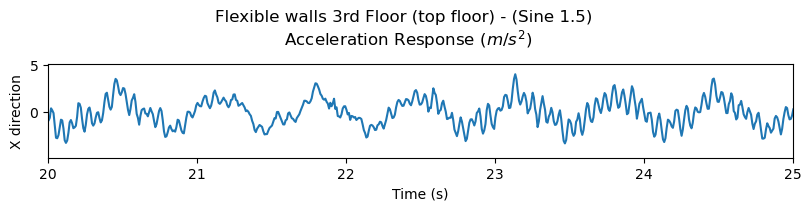

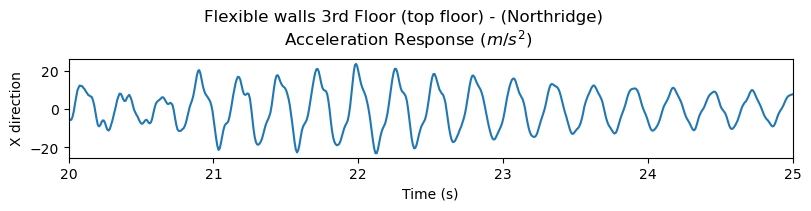

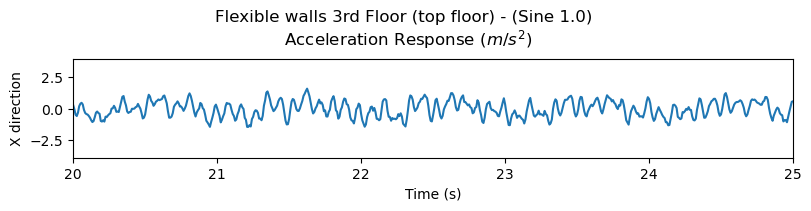

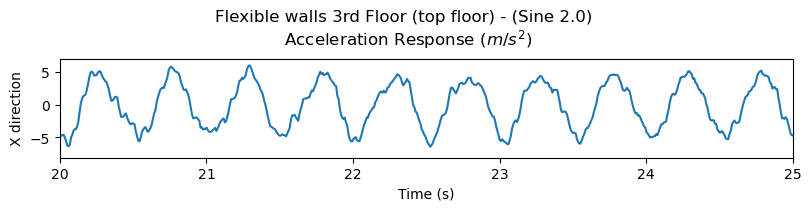

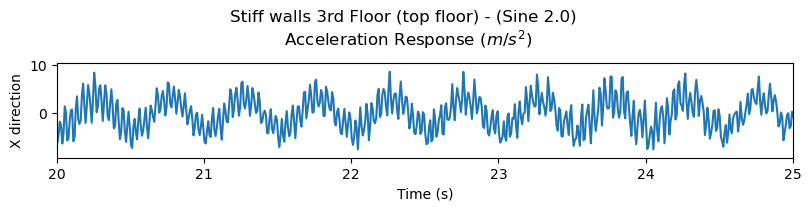

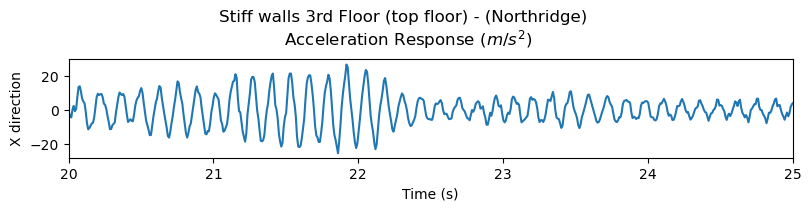

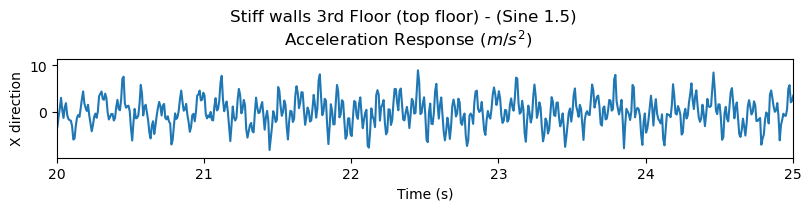

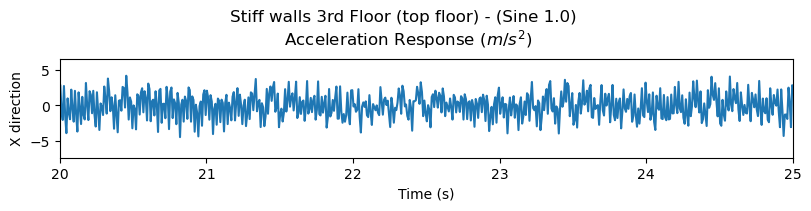

In [5]:
# Path to a directory where we'll save figures
OUT_DIR = Path("out/")
if not OUT_DIR.exists():
    OUT_DIR.mkdir()
# TODO: Fill in this part to plot the records!
for filename,record in data.items():
    if "3rd" in filename:
        num_points = record.shape[0]
        # Create the time array
        time = time_array(TIME_STEP,num_points)
        # Create a plot
        fig,ax = plt.subplots(figsize=(8,2), constrained_layout=True)
        # Plot the X direction, which is the first column of record
        ax.plot(time, record[:,0])
        ax.set_ylabel('X direction')
        # Labels, limits and title
        ax.set_xlabel('Time (s)')
        ax.set_xlim((20,25))
        fig.suptitle(f"{filename} \n Acceleration Response ($m/s^2$)")
        # Save the figure
        fig.savefig(OUT_DIR/f"{filename}.png")

# Perform System Identification.

Given a model trained on the Northridge earthquake record, can we predict the response to the sine wave?

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      0.1355     -0.0006656  1.0        0.9973     0.9973   
      0.1292     0.01822    1.0        0.9953     0.9953   
      0.1277     -0.0005176  1.0        0.9955     0.9955   
      0.1238     -0.0003184  1.0        0.9949     0.9949   
      0.04029    0.001827   1.0        0.9299     0.9299   
      0.03997    0.001928   1.0        0.932      0.932    
      0.03976    0.001735   1.0        0.9297     0.9297   
      0.02536    0.001511   1.0        0.9032     0.9032   
      0.02526    0.001423   1.0        0.8927     0.8927   
      0.02503    0.0002316  1.0        0.9017     0.9017   
Mean Period(s): 0.07119005434526263
Standard Dev(s): 0.04766979539554562


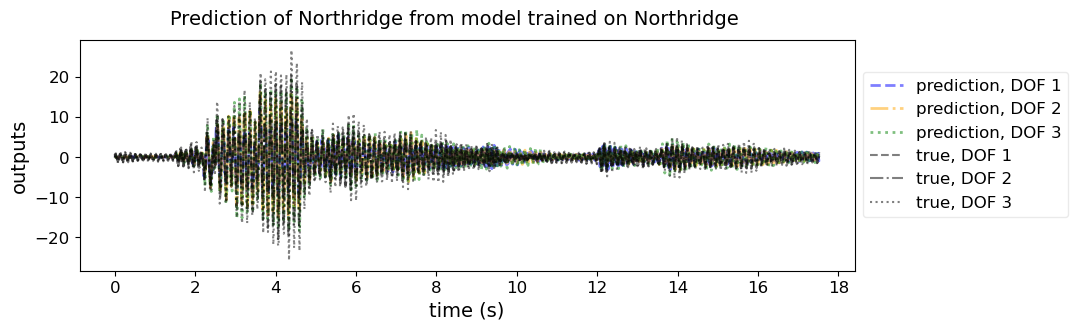

In [6]:
# Train a model based on the Northridge earthquake record.

# Load the X component of the bottom sensor from Northridge as input
inputs = data['Stiff walls Ground Floor - (Northridge)'][:,0]
num_points = int(inputs.shape[0]/6)
inputs = inputs[num_points:2*num_points]
# Load the middle and top sensors from Northridge as outputs
outputs = np.array([data['Stiff walls 1st Floor - (Northridge)'],
                    data['Stiff walls 2nd Floor - (Northridge)'],
                    data['Stiff walls 3rd Floor (top floor) - (Northridge)']
                    ])[:,num_points:2*num_points,0]
# Construct the time array
time = time_array(TIME_STEP, len(inputs))
# Use the mdof package to perform system identification and construct a model
realization = mdof.sysid(inputs,outputs)
# Find the natural modes of vibration of this model
modes = mdof.modal.system_modes(realization,TIME_STEP)
mdof.utilities.print_modes(modes)
# Stabilize the model in case it isn't already stable
from mdof.validation import stabilize_discrete
A_stable = stabilize_discrete(A=realization[0])
realization = (A_stable,*realization[1:])
# Plot the accuracy of the prediction from this model
fig,ax = plt.subplots(figsize=(10,3))
prediction = mdof.simulate.simulate(realization,inputs)
pred_fig = plot_pred(ytrue=outputs,
                     models=prediction,
                     t=time,
                     figax=(fig,ax),
                     title="Prediction of Northridge from model trained on Northridge")

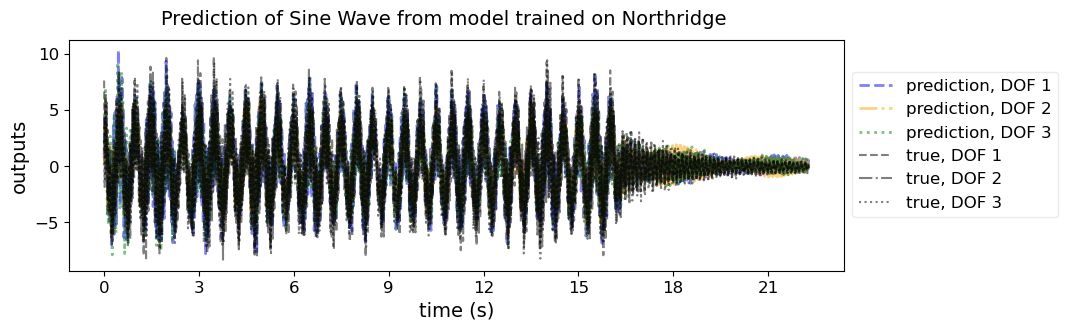

In [7]:
# Test the model on the sine wave record.

# Load the X component of the bottom sensor from SINE WAVE as input
inputs = data['Stiff walls Ground Floor - (Sine 2.0)'][:,0]
num_points = int(inputs.shape[0]/3)
inputs = inputs[num_points:2*num_points]
# Construct the time array
time = time_array(TIME_STEP, len(inputs))
# Plot the accuracy of the prediction from this model
fig,ax = plt.subplots(figsize=(10,3))
prediction = mdof.simulate.simulate(realization,inputs)
# Note that the prediction is made using the inputs and the model trained on Northridge.
# The outputs were not known at the time of prediction.
# Load the middle and top sensors from SINE WAVE as outputs
outputs = np.array([data['Stiff walls 1st Floor - (Sine 2.0)'],
                    data['Stiff walls 2nd Floor - (Sine 2.0)'],
                    data['Stiff walls 3rd Floor (top floor) - (Sine 2.0)']
                    ])[:,num_points:2*num_points,0]
pred_fig = plot_pred(ytrue=outputs,
                     models=prediction,
                     t=time,
                     figax=(fig,ax),
                     title="Prediction of Sine Wave from model trained on Northridge")